## overview

In [1]:
# default package
import logging
import sys 
import os
import pathlib
import IPython
import random
from urllib.request import urlretrieve

In [2]:
# third party package
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from tqdm import tqdm
import pymc3 as pm
import seaborn as sns
import theano.tensor as tt
import scipy.stats as stats
from scipy.stats.mstats import mquantiles

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
# my package
sys.path.append(os.path.join(pathlib.Path().resolve(),"../"))

In [4]:
# reload settings
%load_ext autoreload
%autoreload 2

In [5]:
# logger
logger=logging.getLogger(__name__)
logging.basicConfig(level=logging.ERROR)

In [6]:
# graph setting
sns.set()

## model context

In [7]:
with pm.Model() as model:
    parameter=pm.Exponential("poisson_param",1)
    data_generator=pm.Poisson("data_generator",parameter)
with model:  # same model
    data_plus_one = data_generator + 1

In [8]:
with pm.Model() as ab_testing:
    p_A = pm.Uniform("P(A)", 0, 1)
    p_B = pm.Uniform("P(B)", 0, 1)

## pymc3 variable

In [9]:
with pm.Model() as model:
    lambda_1=pm.Exponential("lambda_1",1)
    lambda_2=pm.Exponential("lambda_2",1)
    tau=pm.DiscreteUniform("tau",lower=0,upper=10)
new_deterministic_variable=lambda_1+lambda_2

## theano

In [10]:
with pm.Model() as theano_test:
    p1 = pm.Uniform("p", 0, 1)
    p2 = 1 - p1
    p = tt.stack([p1, p2])
    
    assignment = pm.Categorical("assignment", p)

## including observations in the model

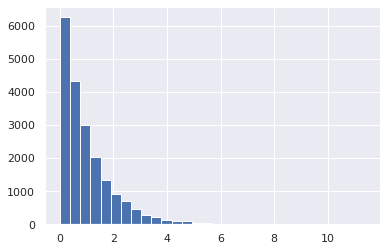

In [11]:
samples=lambda_1.random(size=20000)
plt.hist(samples,bins=30);

In [12]:
data=np.array([10,5])
lambda_=10
with model:
    obs=pm.Poisson("obs",lambda_,observed=data)
print(obs.tag.test_value)

[10  5]


## modeling approaches

In [13]:
tau = np.random.randint(0, 80)
alpha = 1./20.
lambda_1, lambda_2 = np.random.exponential(scale=1/alpha, size=2)
data = np.r_[stats.poisson.rvs(mu=lambda_1, size=tau), stats.poisson.rvs(mu=lambda_2, size = 80 - tau)]

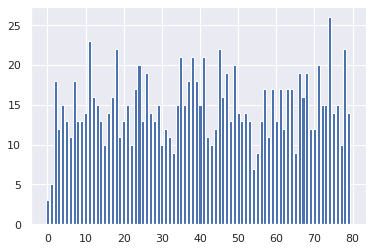

In [14]:
plt.bar(np.arange(80),data);

## A/B test

In [15]:
with pm.Model() as model:
    p=pm.Uniform("p",lower=0,upper=1)

In [16]:
occurrences=stats.bernoulli.rvs(0.05,size=1500)

In [17]:
with model:
    obs=pm.Bernoulli("obs",p,observed=occurrences)
    step=pm.Metropolis()
    trace=pm.sample(18000,step=step,return_inferencedata=False)

Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [p]
INFO:pymc3:Metropolis: [p]


Sampling 4 chains for 1_000 tune and 18_000 draw iterations (4_000 + 72_000 draws total) took 13 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 18_000 draw iterations (4_000 + 72_000 draws total) took 13 seconds.
The number of effective samples is smaller than 25% for some parameters.
INFO:pymc3:The number of effective samples is smaller than 25% for some parameters.


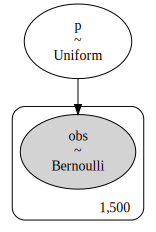

In [18]:
pm.model_to_graphviz(model)

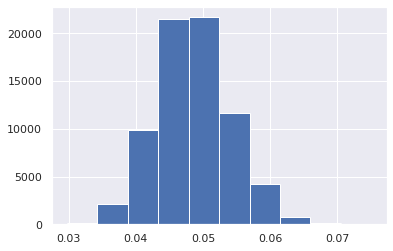

In [19]:
plt.hist(trace["p"]);

## カンニング

In [20]:
N = 100
with pm.Model() as model:
    p = pm.Uniform("freq_cheating", 0, 1)

In [21]:
with model:
    true_answers = pm.Bernoulli("truths", p, shape=N, 
                                testval=np.random.binomial(1, 0.5, N))

In [22]:
with model:
    first_coin_flips = pm.Bernoulli("first_flips", 0.5, shape=N, 
                                    testval=np.random.binomial(1, 0.5, N))

In [23]:
with model:
    second_coin_flips = pm.Bernoulli("second_flips", 0.5, shape=N, 
                                     testval=np.random.binomial(1, 0.5, N))

In [24]:
with model:
    val = first_coin_flips*true_answers + (1 - first_coin_flips)*second_coin_flips
    observed_proportion = pm.Deterministic("observed_proportion", tt.sum(val)/float(N))

In [25]:
X = 35

with model:
    observations = pm.Binomial("obs", N, observed_proportion, observed=X)

In [26]:
with model:
    step = pm.Metropolis(vars=[p])
    trace = pm.sample(10000, step=step,return_inferencedata=False)

Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
INFO:pymc3:CompoundStep
>Metropolis: [freq_cheating]
INFO:pymc3:>Metropolis: [freq_cheating]
>BinaryGibbsMetropolis: [truths, first_flips, second_flips]
INFO:pymc3:>BinaryGibbsMetropolis: [truths, first_flips, second_flips]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 284 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 284 seconds.
The number of effective samples is smaller than 10% for some parameters.


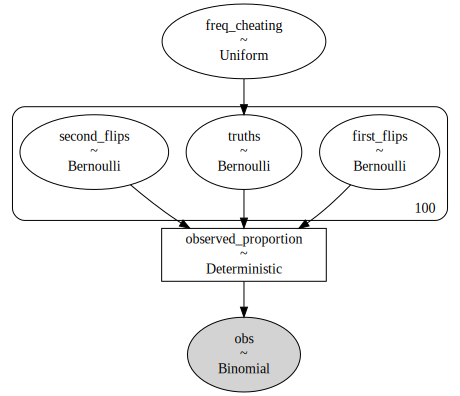

In [27]:
pm.model_to_graphviz(model)

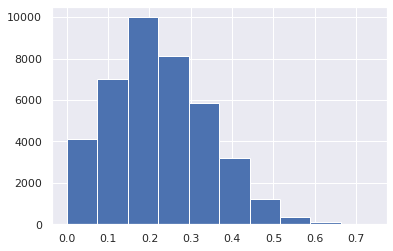

In [28]:
plt.hist(trace["freq_cheating"]);

## Example: Challenger Space Shuttle Disaster

In [29]:
os.makedirs("data",exist_ok=True)
urlretrieve("https://git.io/vXknD","data/challenger.csv")

('data/challenger.csv', <http.client.HTTPMessage at 0x7f0a60db2610>)

In [30]:
df=pd.read_csv("data/challenger.csv").dropna().iloc[:-1]

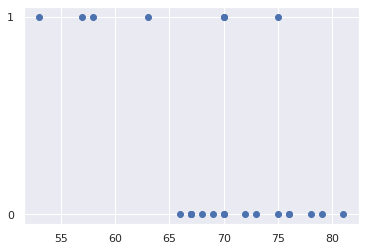

In [31]:
plt.scatter(df["Temperature"],df["Damage Incident"])

In [32]:
temperature=df["Temperature"].values
D=df["Damage Incident"]

In [33]:
with pm.Model() as model:
    beta=pm.Normal("beta",mu=0,tau=0.001,testval=0)
    alpha=pm.Normal("alpha",mu=0,tau=0.001,testval=0)
    p=pm.Deterministic("p",1/(1+tt.exp(beta*temperature+alpha)))
    observed=pm.Bernoulli("bernoulli_obs",p,observed=D)
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(120000, step=step, start=start,return_inferencedata=False)
    burned_trace = trace[100000::2]

Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
INFO:pymc3:CompoundStep
>Metropolis: [alpha]
INFO:pymc3:>Metropolis: [alpha]
>Metropolis: [beta]
INFO:pymc3:>Metropolis: [beta]


Sampling 4 chains for 1_000 tune and 120_000 draw iterations (4_000 + 480_000 draws total) took 70 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 120_000 draw iterations (4_000 + 480_000 draws total) took 70 seconds.
The number of effective samples is smaller than 10% for some parameters.


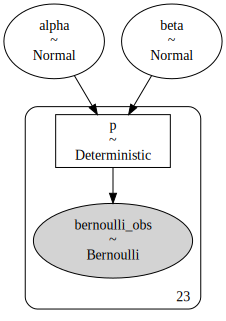

In [34]:
pm.model_to_graphviz(model)

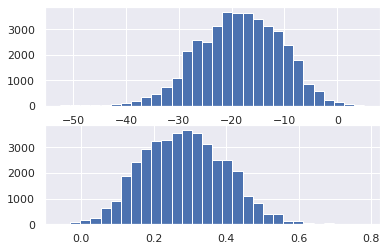

In [35]:
fig,axes=plt.subplots(2)
axes[0].hist(burned_trace["alpha"],bins=30)
axes[1].hist(burned_trace["beta"],bins=30);

In [36]:
def logistic(x, beta, alpha=0):
    return 1.0 / (1.0 + np.exp(np.dot(beta, x) + alpha))

In [37]:
alpha_samples=burned_trace["alpha"][:,None]
beta_samples=burned_trace["beta"][:,None]
t = np.linspace(temperature.min() - 5, temperature.max()+5, 50)[:, None]
p_t = logistic(t.T, beta_samples, alpha_samples)
mean_prob_t = p_t.mean(axis=0)

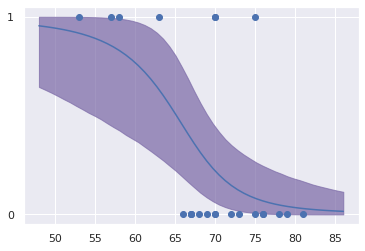

In [38]:
plt.plot(t,mean_prob_t)
qs = mquantiles(p_t, [0.025, 0.975], axis=0)
plt.fill_between(t[:, 0], *qs, alpha=0.7,color="#7A68A6")
plt.scatter(temperature,D)

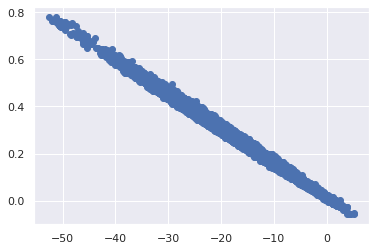

In [39]:
plt.scatter(alpha_samples,beta_samples)